# Prediction from densenet embeddings

Input: 
- csv with disease labels + embeddings extracted using the densenet torch x ray vision model  

Do:  
- train a neural network multiclass classifier to predict the diseases  
- assess bias  

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import StepLR



### Read the CSV

In [4]:
# test = pd.read_csv("../model_dev/densenet_data/densenet_all_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
# train = pd.read_csv("../model_dev/densenet_data/densenet_all_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
# valid = pd.read_csv("../model_dev/densenet_data/densenet_all_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

test_initial = pd.read_csv("../model_dev/densenet_data/densenet_test_predictions.csv", quotechar='"', on_bad_lines='skip')
# train_initial = pd.read_csv("../model_dev/densenet_data/densenet_train_predictions.csv", quotechar='"', on_bad_lines='skip')
# valid_initial = pd.read_csv("../model_dev/densenet_data/densenet_valid_predictions.csv", quotechar='"', on_bad_lines='skip')

print(test_initial.columns)
test_initial.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'Atelectasis.1', 'Consolidation.1',
       'Infiltration', 'Pneumothorax.1', 'Edema.1', 'Emphysema', 'Fibrosis',
       'Effusion', 'Pneumonia.1', 'Pleural_Thickening', 'Cardiomegaly.1',
       'Nodule', 'Mass', 'Hernia', 'Lung Lesion.1', 'Fracture.1',
       'Lung Opacity.1', 'Enlarged Cardiomediastinum.1'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Pneumonia.1,Pleural_Thickening,Cardiomegaly.1,Nodule,Mass,Hernia,Lung Lesion.1,Fracture.1,Lung Opacity.1,Enlarged Cardiomediastinum.1
0,train/patient47347/study3/view1_frontal.jpg,train/patient47347/study3/view1_frontal.dcm,78.0,1,0,1,0,0,1,0,...,0.627497,0.159013,0.965829,0.245335,0.534185,0.553511,0.678016,0.731546,0.953525,0.894168
1,train/patient37527/study12/view1_frontal.jpg,train/patient37527/study12/view1_frontal.dcm,63.0,0,1,2,0,0,0,0,...,0.664034,0.539082,0.612635,0.505365,0.536698,0.025208,0.725883,0.604588,0.869167,0.654336
2,train/patient41208/study9/view1_frontal.jpg,train/patient41208/study9/view1_frontal.dcm,70.0,0,0,1,0,0,0,1,...,0.651837,0.469130,0.544333,0.543463,0.663163,0.308127,0.717720,0.568348,0.767912,0.598184
3,train/patient39357/study1/view1_frontal.jpg,train/patient39357/study1/view1_frontal.dcm,79.0,1,1,1,0,0,0,0,...,0.509472,0.193040,0.645339,0.504483,0.505109,0.032462,0.509491,0.523578,0.619305,0.536065
4,train/patient31982/study4/view1_frontal.jpg,train/patient31982/study4/view1_frontal.dcm,67.0,0,0,0,0,0,0,0,...,0.598874,0.513309,0.771735,0.524469,0.643032,0.071618,0.702488,0.580152,0.854334,0.737613


### Remove columns

In [7]:
test = test_initial.drop(columns=['path_to_image', 'path_to_dcm'])
test

,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,...,Pneumonia.1,Pleural_Thickening,Cardiomegaly.1,Nodule,Mass,Hernia,Lung Lesion.1,Fracture.1,Lung Opacity.1,Enlarged Cardiomediastinum.1
0,78.0,1,0,1,0,0,1,0,0,1,...,0.627497,0.159013,0.965829,0.245335,0.534185,0.553511,0.678016,0.731546,0.953525,0.894168
1,63.0,0,1,2,0,0,0,0,0,0,...,0.664034,0.539082,0.612635,0.505365,0.536698,0.025208,0.725883,0.604588,0.869167,0.654336
2,70.0,0,0,1,0,0,0,1,0,0,...,0.651837,0.469130,0.544333,0.543463,0.663163,0.308127,0.717720,0.568348,0.767912,0.598184
3,79.0,1,1,1,0,0,0,0,0,0,...,0.509472,0.193040,0.645339,0.504483,0.505109,0.032462,0.509491,0.523578,0.619305,0.536065
4,67.0,0,0,0,0,0,0,0,0,0,...,0.598874,0.513309,0.771735,0.524469,0.643032,0.071618,0.702488,0.580152,0.854334,0.737613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40353,35.0,1,1,2,0,0,0,1,0,0,...,0.233085,0.025027,0.759940,0.300455,0.046843,0.000813,0.024455,0.138299,0.301481,0.509839
40354,81.0,1,0,1,0,0,0,1,0,0,...,0.598529,0.508682,0.843562,0.504205,0.519038,0.505410,0.585101,0.575551,0.845472,0.611204
40355,52.0,1,0,2,0,0,0,0,0,0,...,0.619051,0.501918,0.618073,0.510695,0.564480,0.418275,0.562547,0.592051,0.827856,0.667475
40356,47.0,1,0,2,0,0,0,1,0,0,...,0.620225,0.502385,0.518702,0.541378,0.536400,0.013638,0.593770,0.503439,0.642481,0.515170


### Remove rows that were not processed (embeddings = 0)

In [8]:
initial_size = test.shape[0] 
test = test[test['Pneumonia.1'] != 0]
final_size = test.shape[0] 
print(f'Number of test removed rows = {initial_size - final_size}')



Number of test removed rows = 51


### Convert age to binary to study bias

In [9]:
a = 70
test['age'] = (test['age'] >= a).astype(int)

/tmp/ipykernel_192019/250098903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['age'] = (test['age'] >= a).astype(int)


### Visualize distribution of diseases

In [10]:
col = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
            'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'No Finding']

print(f"Distribution in test set")
for disease in col:
    counts = test[disease].value_counts()
    print(f"{disease}:- 0s: {counts.get(0, 0)}, 1s: {counts.get(1, 0)}")


Distribution in test set
Enlarged Cardiomediastinum:- 0s: 38350, 1s: 1957
Cardiomegaly:- 0s: 35347, 1s: 4960
Lung Opacity:- 0s: 20463, 1s: 19844
Lung Lesion:- 0s: 38810, 1s: 1497
Edema:- 0s: 30622, 1s: 9685
Consolidation:- 0s: 37814, 1s: 2493
Pneumonia:- 0s: 39325, 1s: 982
Atelectasis:- 0s: 34107, 1s: 6200
Pneumothorax:- 0s: 36201, 1s: 4106
Pleural Effusion:- 0s: 24418, 1s: 15889
Pleural Other:- 0s: 39739, 1s: 568
Fracture:- 0s: 38699, 1s: 1608
No Finding:- 0s: 36645, 1s: 3662


In [15]:
# Diseases to predict
# diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
            #  'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']


# Labels for train and test
y_test = test[diseases]
y_no_finding = test["No Finding"]
y_sex = test['sex']
y_race = test['race']
y_insurance = test['insurance_type']
y_age = test['age']

In [16]:
y_pred = test[['Cardiomegaly.1', 'Lung Opacity.1', 'Edema.1', 'Atelectasis.1', 'Pneumothorax.1', 'Effusion']]
y_pred.columns = diseases

In [20]:
predictions, targets = y_pred.values, y_test.values

In [22]:
def compute_metrics(predictions, targets):
    # Calculate metrics for each disease
    metrics = {}
    for idx, disease in enumerate(diseases):
        disease_pred = predictions[:, idx]
        disease_true = targets[:, idx]
        auc_roc = roc_auc_score(disease_true, disease_pred)
        f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
        accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
        tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
        
        # Calculate Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
        auprc = auc(recall, precision)

        metrics[disease] = {
            'Accuracy': accuracy,
            'AUC': auc_roc,
            'AUPRC': auprc,
            'F1 Score': f1,
            'TP Rate': tp_rate,
            'FN Rate': fn_rate,
            'TN Rate': tn_rate,
            'FP Rate': fp_rate
        }
    return metrics

metrics = compute_metrics(predictions, targets)
print(metrics)

{'Cardiomegaly': {'Accuracy': 0.2573746495645918, 'AUC': 0.745506223095084, 'AUPRC': 0.2914820723972458, 'F1 Score': 0.24413524910987094, 'TP Rate': 0.9745967741935484, 'FN Rate': 0.025403225806451612, 'TN Rate': 0.1567318301411718, 'FP Rate': 0.8432681698588282}, 'Lung Opacity': {'Accuracy': 0.5817848016473566, 'AUC': 0.6889017764748885, 'AUPRC': 0.6368611158283184, 'F1 Score': 0.693447780465184, 'TP Rate': 0.9607941947188067, 'FN Rate': 0.03920580528119331, 'TN Rate': 0.21424033621658603, 'FP Rate': 0.785759663783414}, 'Edema': {'Accuracy': 0.38521844840846503, 'AUC': 0.7631662606242009, 'AUPRC': 0.46218044998415947, 'F1 Score': 0.4352522904416792, 'TP Rate': 0.9859576664945793, 'FN Rate': 0.014042333505420754, 'TN Rate': 0.1952191235059761, 'FP Rate': 0.8047808764940239}, 'Atelectasis': {'Accuracy': 0.22462599548465528, 'AUC': 0.5725357886991319, 'AUPRC': 0.1722475203854214, 'F1 Score': 0.28056444372827516, 'TP Rate': 0.9829032258064516, 'FN Rate': 0.017096774193548388, 'TN Rate': 0

In [23]:
auc_dict = {}

for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == 'AUC':
            auc_dict[disease] = value

auprc = {}

for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == 'AUPRC':
            auprc[disease] = value

auprc

{'Cardiomegaly': 0.2914820723972458,
 'Lung Opacity': 0.6368611158283184,
 'Edema': 0.46218044998415947,
 'Atelectasis': 0.1722475203854214,
 'Pneumothorax': 0.20951268334977685,
 'Pleural Effusion': 0.6841719375668881}

### Compute metrics for different categories

In [45]:

# Calculate metrics for each disease and for each class

metrics_female = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 1, idx]
    disease_true = targets[y_sex == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_female[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_male = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 0, idx]
    disease_true = targets[y_sex == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_male[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_white = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 0, idx]
    disease_true = targets[y_race == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_white[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_black = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 2, idx]
    disease_true = targets[y_race == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_black[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_asian = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 1, idx]
    disease_true = targets[y_race == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_asian[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_medicaid = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 0, idx]
    disease_true = targets[y_insurance == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicaid[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_medicare = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 1, idx]
    disease_true = targets[y_insurance == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicare[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_private = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 2, idx]
    disease_true = targets[y_insurance == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_private[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_young = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 0, idx]
    disease_true = targets[y_age == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_young[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_old = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 1, idx]
    disease_true = targets[y_age == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_old[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

In [46]:
# Initialize an empty list to store the data
data_sex = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_male = metrics_male[disease]['AUC'] *100
    auc_female = metrics_female[disease]['AUC'] *100
    tp_rate_male = metrics_male[disease]['TP Rate'] *100
    tp_rate_female = metrics_female[disease]['TP Rate'] *100
    fp_rate_male = metrics_male[disease]['FP Rate'] *100
    fp_rate_female = metrics_female[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_sex = abs(auc_male - auc_female)
    eq_odds_sex = 0.5 * (abs(tp_rate_male - tp_rate_female) + abs(fp_rate_male - fp_rate_female))
    
    # Append to the data list
    data_sex.append([disease, auprc_overall, auc_overall, auc_male, auc_female, delta_auc_sex, eq_odds_sex])

# Create a DataFrame
df_sex = pd.DataFrame(data_sex, columns=['Disease', 'AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_sex.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_Male': "{:.3f}", 
    'AUC_Female': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_Male,AUC_Female,Delta AUC,EqOdds
0,Cardiomegaly,29.148,74.551,74.568,74.474,0.094,1.213
1,Lung Opacity,63.686,68.890,69.050,68.670,0.380,0.146
2,Edema,46.218,76.317,76.202,76.465,0.262,0.363
3,Atelectasis,17.225,57.254,56.956,57.603,0.647,0.712
4,Pneumothorax,20.951,69.447,68.857,70.215,1.358,2.629
5,Pleural Effusion,68.417,80.664,79.915,81.671,1.755,0.656


In [47]:
# Initialize an empty list to store the data
data_race = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_white[disease]['AUC'] *100,
        metrics_black[disease]['AUC'] *100,
        metrics_asian[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_white[disease]['TP Rate'] *100,
        metrics_black[disease]['TP Rate'] *100,
        metrics_asian[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_white[disease]['FP Rate'] *100,
        metrics_black[disease]['FP Rate'] *100,
        metrics_asian[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_race = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_race = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_race.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_race, eq_odds_race])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds']
df_race = pd.DataFrame(data_race, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_race.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_White': "{:.3f}", 
    'AUC_Black': "{:.3f}",
    'AUC_Asian': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_White,AUC_Black,AUC_Asian,Max Delta AUC,Max EqOdds
0,Cardiomegaly,29.148,74.551,73.976,76.427,76.107,2.452,0.574
1,Lung Opacity,63.686,68.890,68.516,71.109,69.645,2.593,1.935
2,Edema,46.218,76.317,76.518,73.881,77.051,3.170,2.089
3,Atelectasis,17.225,57.254,56.913,58.096,58.346,1.434,1.099
4,Pneumothorax,20.951,69.447,68.906,73.461,70.199,4.555,2.827
5,Pleural Effusion,68.417,80.664,80.360,80.943,81.803,1.443,1.206


In [48]:
# Initialize an empty list to store the data
data_age = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_old = metrics_old[disease]['AUC'] *100
    auc_young = metrics_young[disease]['AUC'] *100
    tp_rate_old = metrics_old[disease]['TP Rate'] *100
    tp_rate_young = metrics_young[disease]['TP Rate'] *100
    fp_rate_old = metrics_old[disease]['FP Rate'] *100
    fp_rate_young = metrics_young[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_age = abs(auc_old - auc_young)
    eq_odds_age = 0.5 * (abs(tp_rate_old - tp_rate_young) + abs(fp_rate_old - fp_rate_young))
    
    # Append to the data list
    data_age.append([disease, auprc_overall, auc_overall, auc_old, auc_young, delta_auc_age, eq_odds_age])

# Create a DataFrame
df_age = pd.DataFrame(data_age, columns=['Disease', 'AUPRC', 'AUC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_age.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_old': "{:.3f}", 
    'AUC_young': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC', 'AUPRC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_old,AUC_young,Delta AUC,EqOdds
0,Cardiomegaly,29.148,74.551,72.224,75.058,2.834,8.828
1,Lung Opacity,63.686,68.890,64.502,71.027,6.525,9.326
2,Edema,46.218,76.317,74.465,77.068,2.603,6.691
3,Atelectasis,17.225,57.254,54.751,58.957,4.206,5.757
4,Pneumothorax,20.951,69.447,68.446,69.983,1.537,2.835
5,Pleural Effusion,68.417,80.664,79.520,81.229,1.709,8.487


In [49]:
# Initialize an empty list to store the data
data_health = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_medicaid[disease]['AUC'] *100,
        metrics_medicare[disease]['AUC'] *100,
        metrics_private[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_medicaid[disease]['TP Rate'] *100,
        metrics_medicare[disease]['TP Rate'] *100,
        metrics_private[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_medicaid[disease]['FP Rate'] *100,
        metrics_medicare[disease]['FP Rate'] *100,
        metrics_private[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_health = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_health = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_health.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_health, eq_odds_health])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds']
df_health = pd.DataFrame(data_health, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_health.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_Medicaid': "{:.3f}", 
    'AUC_Medicare': "{:.3f}",
    'AUC_Private': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC',  'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_Medicaid,AUC_Medicare,AUC_Private,Max Delta AUC,Max EqOdds
0,Cardiomegaly,29.148,74.551,78.304,73.430,74.352,4.874,8.867
1,Lung Opacity,63.686,68.890,72.243,66.490,72.684,6.194,8.337
2,Edema,46.218,76.317,73.911,75.350,78.720,4.809,6.779
3,Atelectasis,17.225,57.254,60.068,55.199,61.053,5.854,5.952
4,Pneumothorax,20.951,69.447,70.462,69.148,69.628,1.314,2.284
5,Pleural Effusion,68.417,80.664,82.108,79.886,81.637,2.223,8.029


In [ ]:
# Initialize an empty list to store the data
data = []
i=0
# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():

    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100

    # Append to the data list
    data.append([disease, auprc_overall, auc_overall] + [df_sex['Delta AUC'][i], df_sex['EqOdds'][i]] + [df_race['Max Delta AUC'][i], df_race['Max EqOdds'][i]] + [df_age['Delta AUC'][i], df_age['EqOdds'][i]] + [df_health['Max Delta AUC'][i], df_health['Max EqOdds'][i]])
    i+=1
# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health']
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'Delta AUC sex': "{:.3f}", 
    'EqOdds sex': "{:.3f}",
    'Delta AUC race': "{:.3f}", 
    'EqOdds race': "{:.3f}",
    'Delta AUC age': "{:.3f}", 
    'EqOdds age': "{:.3f}",
    'Delta AUC health': "{:.3f}", 
    'EqOdds health': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC',  'AUPRC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,Delta AUC sex,EqOdds sex,Delta AUC race,EqOdds race,Delta AUC age,EqOdds age,Delta AUC health,EqOdds health
0,Cardiomegaly,29.148,74.551,0.094,1.213,2.452,0.574,2.834,8.828,4.874,8.867
1,Lung Opacity,63.686,68.890,0.380,0.146,2.593,1.935,6.525,9.326,6.194,8.337
2,Edema,46.218,76.317,0.262,0.363,3.170,2.089,2.603,6.691,4.809,6.779
3,Atelectasis,17.225,57.254,0.647,0.712,1.434,1.099,4.206,5.757,5.854,5.952
4,Pneumothorax,20.951,69.447,1.358,2.629,4.555,2.827,1.537,2.835,1.314,2.284
5,Pleural Effusion,68.417,80.664,1.755,0.656,1.443,1.206,1.709,8.487,2.223,8.029


### Study a specific metric and compare

In [51]:
met = 'AUPRC'  #Accuracy, AUC, F1 Score, TP Rate, FN Rate

In [52]:
# Compute metrics for each disease
auc_general = {}
for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == met:
            auc_general[disease] = value

print(f"General {met}", auc_general)


General AUPRC {'Cardiomegaly': 0.2914820723972458, 'Lung Opacity': 0.6368611158283184, 'Edema': 0.46218044998415947, 'Atelectasis': 0.1722475203854214, 'Pneumothorax': 0.20951268334977685, 'Pleural Effusion': 0.6841719375668881}


In [53]:
# Initialize dictionaries to store AUC values
auc_female = {}
auc_male = {}

for disease, values in metrics_female.items():
    for metric, value in values.items():
        if metric == met:
            auc_female[disease] = value

for disease, values in metrics_male.items():
    for metric, value in values.items():
        if metric == met:
            auc_male[disease] = value

# Output results
print(f"{met} for Females: {auc_female}")
print(f"{met} for Males: {auc_male}")


AUPRC for Females: {'Cardiomegaly': 0.2813860383724121, 'Lung Opacity': 0.6392938451682522, 'Edema': 0.4742246538493975, 'Atelectasis': 0.16691539621066548, 'Pneumothorax': 0.21226472997568505, 'Pleural Effusion': 0.6965366054375367}
AUPRC for Males: {'Cardiomegaly': 0.2995385385655539, 'Lung Opacity': 0.6350164465485686, 'Edema': 0.4533696106312412, 'Atelectasis': 0.176078268554486, 'Pneumothorax': 0.20782478874195118, 'Pleural Effusion': 0.6744506749504922}


In [54]:
# Initialize dictionaries to store AUC values
auc_white = {}
auc_black = {}
auc_asian = {}

for disease, values in metrics_white.items():
    for metric, value in values.items():
        if metric == met:
            auc_white[disease] = value

for disease, values in metrics_asian.items():
    for metric, value in values.items():
        if metric == met:
            auc_asian[disease] = value

for disease, values in metrics_black.items():
    for metric, value in values.items():
        if metric == met:
            auc_black[disease] = value

# Output results
print(f"{met} for W: {auc_white}")
print(f"{met} for B: {auc_black}")
print(f"{met} for A: {auc_asian}")


AUPRC for W: {'Cardiomegaly': 0.2678748720722645, 'Lung Opacity': 0.635000663732181, 'Edema': 0.47187998275626597, 'Atelectasis': 0.175112685435107, 'Pneumothorax': 0.2025512942200675, 'Pleural Effusion': 0.6831913496471331}
AUPRC for B: {'Cardiomegaly': 0.4404668498836664, 'Lung Opacity': 0.6331345439093806, 'Edema': 0.45250777900636757, 'Atelectasis': 0.15261114721393604, 'Pneumothorax': 0.20639596249269088, 'Pleural Effusion': 0.612660723557627}
AUPRC for A: {'Cardiomegaly': 0.3472207558468975, 'Lung Opacity': 0.6485765860891038, 'Edema': 0.41537375885944927, 'Atelectasis': 0.16498024071594175, 'Pneumothorax': 0.24701039354770085, 'Pleural Effusion': 0.7149748213476558}


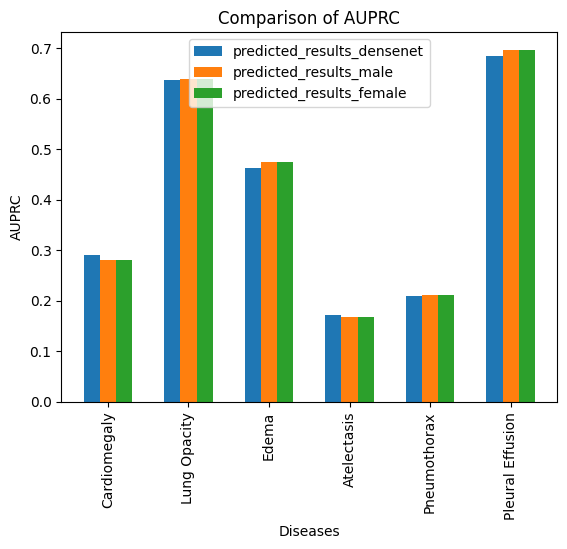

In [55]:

# Extract diseases and AUC values
diseases_to_plot = list(auc_general.keys())
values2 = [auc_general[disease] for disease in diseases_to_plot]
values_male = [auc_female[disease] for disease in diseases_to_plot]
values_female = [auc_female[disease] for disease in diseases_to_plot]

# Setting the positions and width for the bars
positions = np.arange(len(diseases_to_plot))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions, values_male, width=bar_width, label='predicted_results_male')
bar4 = ax.bar(positions + bar_width, values_female, width=bar_width, label='predicted_results_female')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()


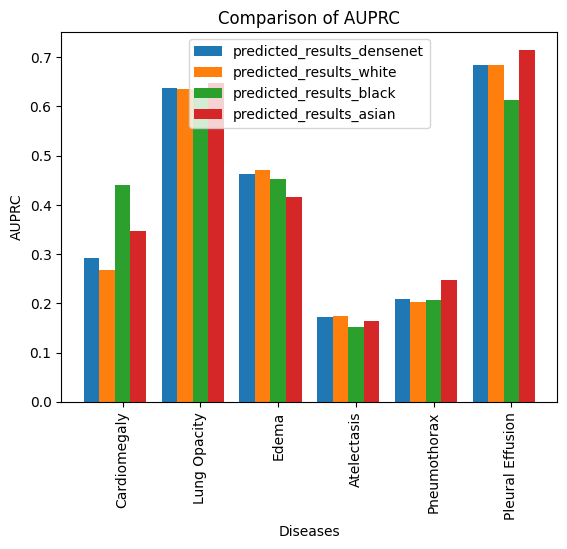

In [56]:

# Extract diseases and AUC values
diseases = list(auc_general.keys())
values2 = [auc_general[disease] for disease in diseases]
values_white = [auc_white[disease] for disease in diseases]
values_black = [auc_black[disease] for disease in diseases]
values_asian = [auc_asian[disease] for disease in diseases]

# Setting the positions and width for the bars
positions = np.arange(len(diseases))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - 2*bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions - bar_width, values_white, width=bar_width, label='predicted_results_white')
bar4 = ax.bar(positions, values_black, width=bar_width, label='predicted_results_black')
bar5 = ax.bar(positions + bar_width, values_asian, width=bar_width, label='predicted_results_asian')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()
